## Author: Yuqing Qiao
## Date: 05/24/2024

## Data collection and preprocessing

### prepare dataset NLTK reuters

In [2]:
import nltk
nltk.download('reuters')
nltk.download('gutenberg')
from nltk.corpus import reuters,gutenberg

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


In [3]:
document_ids = reuters.fileids()[:5]
print(document_ids)


['test/14826', 'test/14828', 'test/14829', 'test/14832', 'test/14833']


In [4]:
guten_document_ids = gutenberg.fileids()[-1]
print("guten: ",guten_document_ids)


guten:  whitman-leaves.txt


In [5]:
# document_id = 'test/14930'
# words = reuters.words(document_id)
# document = " ".join(words)

documents = [" ".join(reuters.words(id)) for id in document_ids]

In [82]:
documents[0][:200]

"ASIAN EXPORTERS FEAR DAMAGE FROM U . S .- JAPAN RIFT Mounting trade friction between the U . S . And Japan has raised fears among many of Asia ' s exporting nations that the row could inflict far - re"

In [6]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

lem = nltk.WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### clean and preprocess the data

In [7]:
import re
import string

def clean_text(text):
    """ removing stopwords lemmatize and non-alphabetic tokens."""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)   # Remove non-alphanumeric characters

    text_punct_removed = "".join([char for char in text if char not in string.punctuation])

    tokens = word_tokenize(text_punct_removed)
    tokens = [word for word in tokens if word not in stop_words]

    tokens = [lem.lemmatize(word) for word in tokens]

    return tokens


In [8]:
cleaned = [clean_text(doc) for doc in documents]
cleaned[0][:5]

['asian', 'exporter', 'fear', 'damage', 'u']

### Model implementation



In [18]:
from collections import defaultdict, Counter

class NgramModel:
    def __init__(self, documents, n) -> None:
        self.n = n
        self.tokens = clean_text(" ".join(documents))
        self.vocab_size = len(set(self.tokens))
        self.ngram_freq = self.generate_ngrams(self.tokens,n)
        self.n_1_gram_freq = self.generate_ngrams(self.tokens, n-1)
        self.prob_cache={}

    def generate_ngrams(self, tokens, n):
        """
        2.a
        Create n-grams from the tokenized text and calculate their frequencies in the
        dataset
        """
        ngrams = [" ".join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
        return Counter(ngrams);

    def prob(self, prefix, word):
        """
        2.b 2.e
        alculate the probability of a word following a given (n − 1)-
        gram.
        """
        if(prefix,word) in self.prob_cache:
            return self.prob_cache[(prefix,word)]

        ngram = prefix + " " + word
        ngram_count = self.ngram_freq.get(ngram, 0)
        previous_n_1_gram_count = self.n_1_gram_freq.get(prefix, 0)

        if previous_n_1_gram_count == 0:
            return 0
        else:
            probability = (ngram_count+1) / (previous_n_1_gram_count + self.vocab_size) # smoothing

        self.prob_cache[(prefix,word)] = probability

        return probability


    def predict_next_word(self, prefix):
        """
        2.c
        Predict the next word given a sequence of words based on these
        probabilities.

        """
        probabilities = {word: self.prob(prefix,word) for word in set(self.tokens)}
        next_word = max(probabilities, key = probabilities.get)

        print(f"Predicted next word: {next_word}, Probability: {probabilities[next_word]:.8f}")

        return next_word


    def generate_sequence(self, prefix, length):
        """
        2.d
        function to generate a sentence of a specified length given a prefix of (n−1)
        words.
        """
        prefix_tokens = clean_text(prefix)
        if length <= len(prefix_tokens):
            raise ValueError("Length is shorter than prefix length.")

        for _ in range(length - len(prefix_tokens)):
            next_word = self.predict_next_word(" ".join(prefix_tokens[-(self.n - 1):]))
            prefix_tokens.append(next_word)

        return " ".join(prefix_tokens)


### Testing and evaluation

In [10]:
"""
3.a test the model by inputting various (n − 1)-gram sequences and evaluating its
ability to generate text.
"""

prefix = "asian exporter fear"
train_documents = [" ".join(reuters.words(id)) for id in reuters.fileids()[:-1]]

#load ngram model
model = NgramModel(documents=train_documents,n=3)

generated = model.generate_sequence(prefix,10)

print("\n\ngenerated sentence: ", generated)


Predicted next word: damage, Probability: 7.515406583496167e-05
Predicted next word: u, Probability: 7.51597143930853e-05
Predicted next word: raid, Probability: 7.515406583496167e-05
Predicted next word: coming, Probability: 7.514559458951719e-05
Predicted next word: day, Probability: 7.51597143930853e-05
Predicted next word: scepticism, Probability: 0.0001127141568981064
Predicted next word: mount, Probability: 0.00011273533501183721


generated sentence:  asian exporter fear damage u raid coming day scepticism mount


In [10]:
# Get the top K elements
k=10
top_k = model.ngram_freq.most_common(k)

# Print the top K elements
print(f"Top {k} elements:")
for element, count in top_k:
    print(f"{element}: {count}")

Top 10 elements:
mln v mln: 3403
ct v ct: 1784
rev mln v: 1583
shr ct v: 1447
v ct net: 1168
ct net v: 1097
net v rev: 935
v rev mln: 752
v mln note: 750
ct v loss: 699


### perplexity of the model

In [11]:
import math
from tqdm.auto import tqdm

def compute_perplexity(model, test_documents):
    """
    Compute the perplexity of the NgramModel on a list of test documents.

    :param model: An instance of NgramModel
    :param test_documents: A list of test documents (each document is a string)
    :return: The perplexity of the model on the test set
    """
    log_prob_sum = 0
    N = 0  # Total number of words in the test set
    log_cache = {}

    def get_log_prob(prob):
        if prob not in log_cache:
            log_cache[prob] = math.log(prob)
        return log_cache[prob]

    for document in tqdm(test_documents,desc="Processing Documents",leave=True):
        tokens = clean_text(document)
        N += len(tokens)

        for i in range(len(tokens) - model.n + 1):
            prefix = tuple(tokens[i:i + model.n - 1])
            word = tokens[i + model.n - 1]
            probability = model.prob(" ".join(prefix), word)
            if probability > 0:
                log_prob_sum += get_log_prob(probability)
            else:
                # Handling the case where the model assigns 0 probability
                log_prob_sum += get_log_prob(1e-12)

    # Calculate the average negative log probability
    avg_neg_log_prob = -log_prob_sum / N

    # Compute the perplexity
    perplexity = math.exp(avg_neg_log_prob)

    return perplexity


### Prepare train test split dataset

In [11]:
import random
# Prepare the documents
documents = [" ".join(reuters.words(fileid)) for fileid in reuters.fileids()]

# Shuffle the documents
random.shuffle(documents)

# Split into train and test sets
split_index = int(len(documents) * 0.9)  # 80-20 split
train_documents = documents[:split_index]
test_documents = documents[split_index:]

# Print the number of documents in each set to verify
print(f"Number of training documents: {len(train_documents)}")
print(f"Number of test documents: {len(test_documents)}")

Number of training documents: 9709
Number of test documents: 1079


In [13]:
# bigram perplexity
bigram_model = NgramModel(train_documents,n=2)
perplexity = compute_perplexity(bigram_model, test_documents)

print("\n")
print("Perplexity: ", perplexity)


Processing Documents:   0%|          | 0/1079 [00:00<?, ?it/s]



Perplexity:  5091.799498544866


In [68]:
tri_gram_model = NgramModel(train_documents,n=3)
tri_gram_perplexity = compute_perplexity(model, test_documents)

print("\n\nPerplexity: ", tri_gram_perplexity)


Processing Documents:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Tokens:   0%|          | 0/65028 [00:00<?, ?it/s]



Perplexity:  13937.094770407739


### Perplexities for different ngram model size

In [18]:
# Compute perplexity for different n

import multiprocessing
from tqdm.auto import tqdm

def compute_ngram_perplexity(n):
    ngram_model = NgramModel(train_documents, n=n)
    perplexity = compute_perplexity(ngram_model, test_documents)
    return perplexity


step_n = 1
steps = list(range(2, 30, step_n))  # n values from 2 to 29
num_processes = multiprocessing.cpu_count()  # Use all available CPUs

with multiprocessing.Pool(num_processes) as pool:
    results = list(tqdm(pool.imap(compute_ngram_perplexity, steps), total=len(steps), desc="process ngram models perplexities", leave=True))

perplexities = results
print(perplexities)


process ngram models perplexities: 100%|██████████| 28/28 [05:49<00:00, 12.48s/it]

[5091.799498544866, 3371268.085155201, 629916846.9743656, 3895919544.945528, 6994008138.997976, 8408570468.775749, 8348854922.24991, 7552198457.915665, 6494074871.025835, 5442108411.168067, 4466319034.030815, 3601875000.7799587, 2845225449.087509, 2213538212.556518, 1700888785.997391, 1297555145.873784, 987771929.056117, 752719333.1489354, 575698765.4562482, 441193985.5666247, 339988179.8826727, 261642882.8583962, 201948654.36451164, 155813832.1668155, 120417158.02932407, 92946405.50592889, 71720684.50211473, 55519438.3023575]


In [19]:
## perplexities preview
perplexities[:3]

[5091.799498544866, 3371268.085155201, 629916846.9743656]

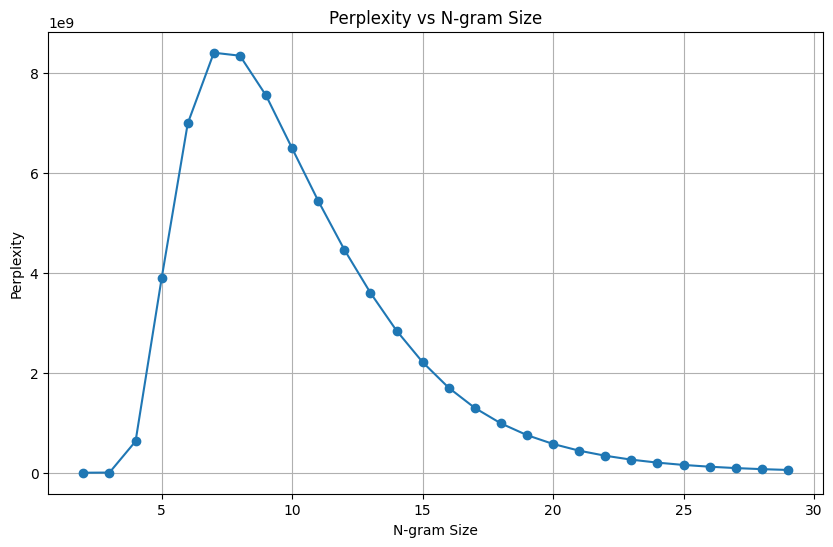

In [20]:
import matplotlib.pyplot as plt
# Plot the perplexity graph
plt.figure(figsize=(10, 6))
plt.plot(steps, perplexities, marker='o')
plt.title('Perplexity vs N-gram Size')
plt.xlabel('N-gram Size')
plt.ylabel('Perplexity')
plt.grid(True)
plt.show()

In [ ]:
test_documents[0][:100]
clean_text(test_documents[0][:200])

### UI bonus

In [23]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import random

model = NgramModel(train_documents, 7)

# Example completion function
def complete_prefix(prefix, max_length):
    return model.generate_sequence(prefix, max_length)

# UI Elements
prefix_input = widgets.Text(
    value='fear damage',
    placeholder='Enter a prefix',
    description='Prefix:',
    disabled=False
)

length_input = widgets.IntSlider(
    value=10,
    min=1,
    max=100,
    step=1,
    description='Max Length:',
    continuous_update=False,
    orientation='horizontal'
)

submit_button = widgets.Button(
    description='Submit',
    button_style='', # options are 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to generate text'
)

output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output()
        prefix = prefix_input.value
        max_length = length_input.value
        completion = complete_prefix(prefix, max_length)
        print(f"Completions for '{prefix}' up to length {max_length}:")
        print(completion)

# Link the button to the function
submit_button.on_click(on_button_clicked)

print("\n")
# Display the UI
display(prefix_input, length_input, submit_button, output)

Text(value='fear damage', description='Prefix:', placeholder='Enter a prefix')

IntSlider(value=10, continuous_update=False, description='Max Length:', min=1)

Button(description='Submit', style=ButtonStyle(), tooltip='Click to generate text')

Output()

### ngram freq top k ngrams preview [debug]

In [26]:
model.ngram_freq.most_common(10)

[('ct net v rev mln v mln', 415),
 ('shr ct v ct net v rev', 410),
 ('v ct net v rev mln v', 391),
 ('net shr ct v ct net v', 380),
 ('ct v ct net v rev mln', 378),
 ('qtr net shr ct v ct net', 253),
 ('mln v mln avg shrs mln v', 223),
 ('v mln avg shrs mln v mln', 211),
 ('shr ct v ct net v sale', 197),
 ('ct net v sale mln v mln', 195)]